In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, roc_auc_score
import joblib
import math
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
df=pd.read_csv("D:/Insurance_AI_project/datasets/insurance_claims_dataset.csv")

In [4]:
df.head()

,Policy_ID,Customer_Age,Gender,Policy_Type,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount
0,POL000001,56,Female,Life,95476.49,5,0,834.08,46875.18
1,POL000002,69,Other,Property,102194.36,0,0,1518.58,30204.26
2,POL000003,46,Female,Life,21702.28,6,0,3786.11,23722.70
3,POL000004,32,Other,Life,106259.86,0,0,3194.64,3079.85
4,POL000005,60,Other,Auto,43144.68,4,0,790.21,33614.95


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Policy_ID         500 non-null    object 
 1   Customer_Age      500 non-null    int64  
 2   Gender            500 non-null    object 
 3   Policy_Type       500 non-null    object 
 4   Annual_Income     500 non-null    float64
 5   Claim_History     500 non-null    int64  
 6   Fraudulent_Claim  500 non-null    int64  
 7   Premium_Amount    500 non-null    float64
 8   Claim_Amount      500 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 35.3+ KB


In [6]:
df.describe()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,49.910000,84716.432920,4.390000,0.136000,2776.391000,25834.187640
std,18.221909,38698.241877,2.859064,0.343132,1304.709559,14213.463889
min,18.000000,20830.160000,0.000000,0.000000,509.470000,122.090000
25%,35.000000,49568.657500,2.000000,0.000000,1650.167500,14063.910000
50%,50.000000,86310.160000,4.000000,0.000000,2875.560000,25980.650000
75%,66.000000,118663.945000,7.000000,0.000000,3879.022500,38647.650000
max,79.000000,149731.430000,9.000000,1.000000,4998.710000,49977.240000


In [4]:
# Handle missing values
df.isnull().sum()

Policy_ID           0
Customer_Age        0
Gender              0
Policy_Type         0
Annual_Income       0
Claim_History       0
Fraudulent_Claim    0
Premium_Amount      0
Claim_Amount        0
dtype: int64

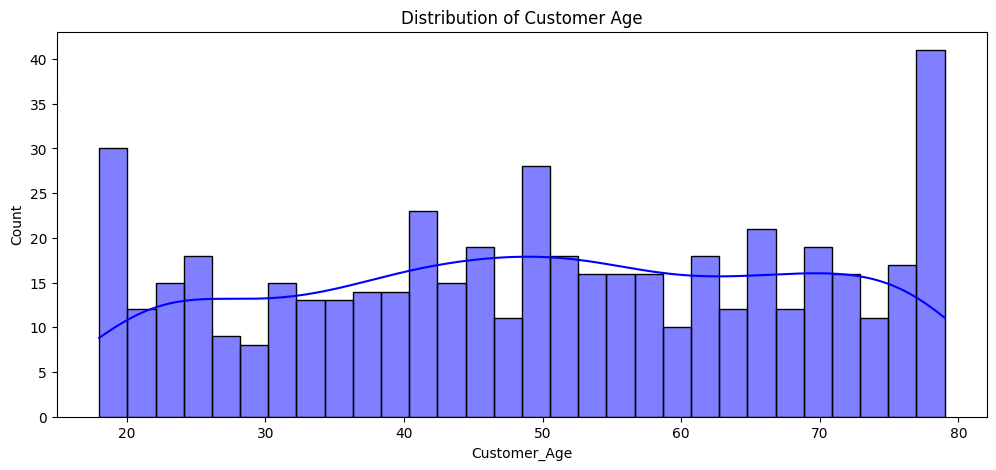

In [7]:
# Univariate Analysis
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.histplot(df['Customer_Age'], bins=30, kde=True, color='blue')
plt.title('Distribution of Customer Age')
plt.show()

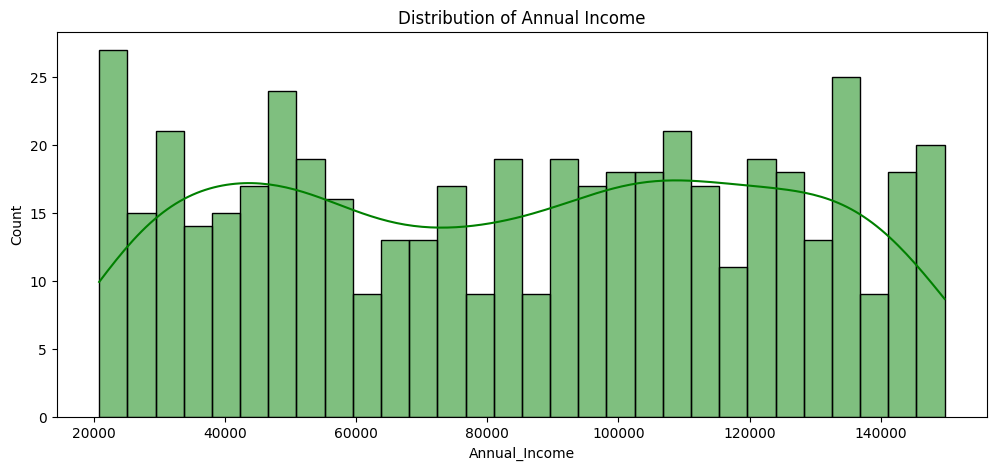

In [8]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Annual_Income'], bins=30, kde=True, color='green')
plt.title('Distribution of Annual Income')
plt.show()

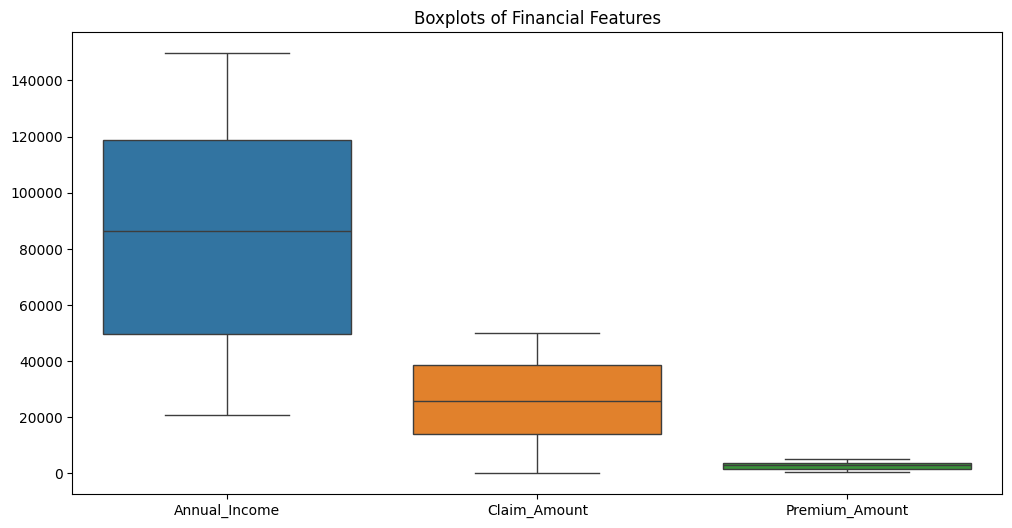

In [10]:
# Boxplots for outliers
target_cols = ['Annual_Income', 'Claim_Amount', 'Premium_Amount']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[target_cols])
plt.title("Boxplots of Financial Features")
plt.show()

C:\Users\naveen\AppData\Local\Temp\ipykernel_12408\3887177502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Policy_Type', palette='muted')


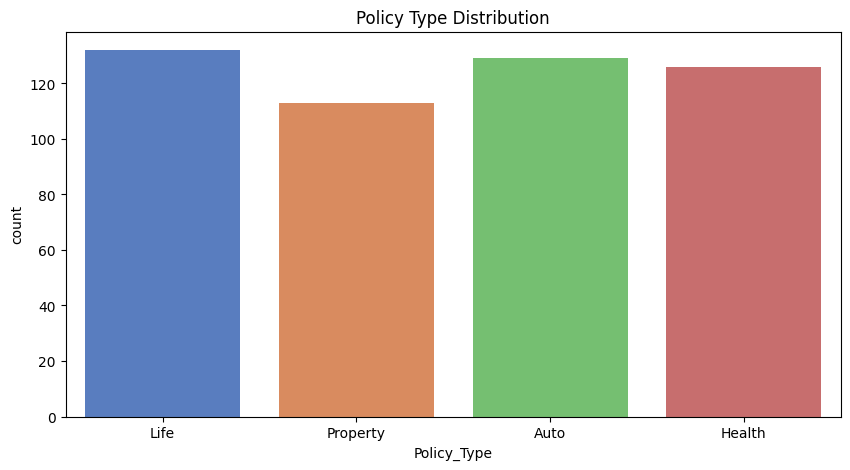

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Policy_Type', palette='muted')
plt.title('Policy Type Distribution')
plt.show()

C:\Users\naveen\AppData\Local\Temp\ipykernel_12408\1137039950.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Policy_Type', y='Claim_Amount', data=df, palette='coolwarm')


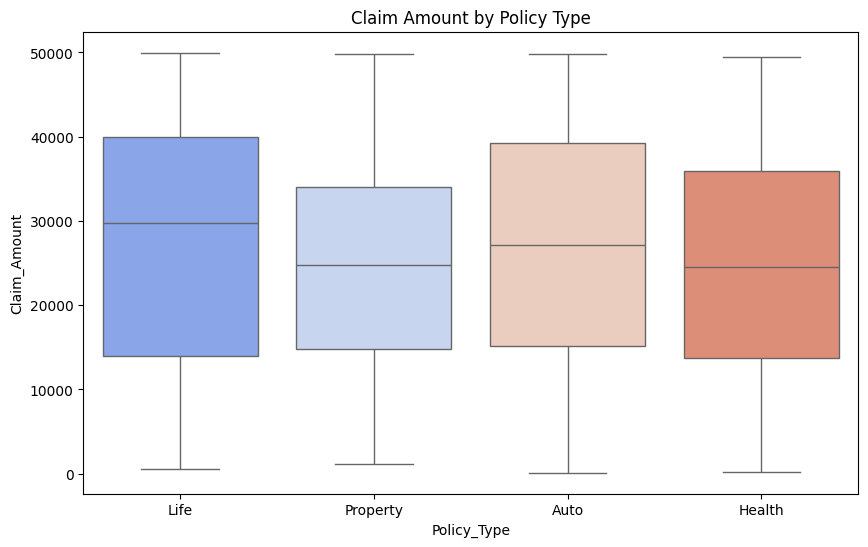

In [12]:
# Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='Policy_Type', y='Claim_Amount', data=df, palette='coolwarm')
plt.title('Claim Amount by Policy Type')
plt.show()

C:\Users\naveen\AppData\Local\Temp\ipykernel_12408\3254317703.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fraudulent_Claim', y='Annual_Income', data=df, palette='coolwarm')


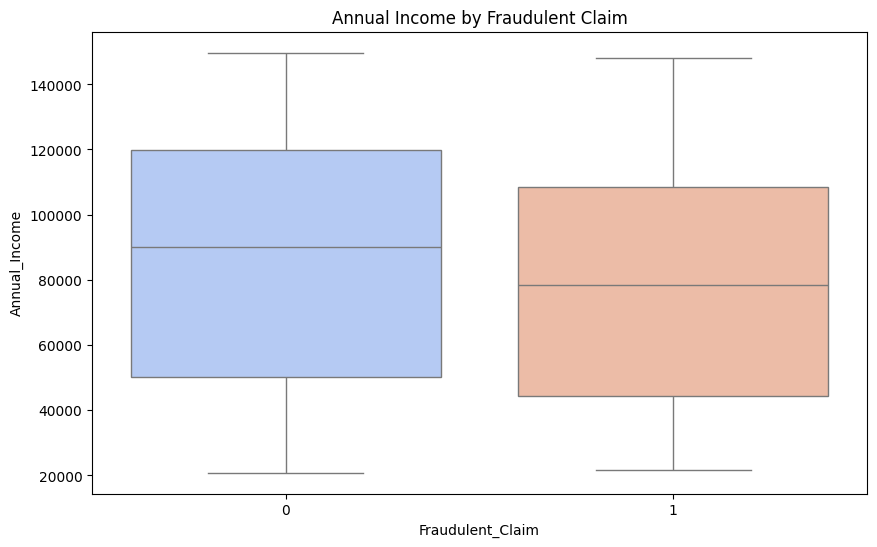

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraudulent_Claim', y='Annual_Income', data=df, palette='coolwarm')
plt.title('Annual Income by Fraudulent Claim')
plt.show()

In [6]:
# Function to assign Risk_Score based on given criteria
def assign_risk_score(row):
    if row["Fraudulent_Claim"] == 1 or row["Claim_History"] > 5 or row["Claim_Amount"] > 30000:
        return "High"
    elif 3 <= row["Claim_History"] <= 5 or (10000 < row["Claim_Amount"] <= 30000):
        return "Medium"
    else:
        return "Low"

# Apply function to DataFrame
df["Risk_Score"] = df.apply(assign_risk_score, axis=1)

In [7]:
df=df.drop("Policy_ID", axis=1)

In [8]:
# Convert Risk_Score to numeric values first
risk_mapping = {"Low": 0, "Medium": 1, "High": 2}
df["Risk_Score"] = df["Risk_Score"].map(risk_mapping)

# Ensure categorical columns are properly encoded
categorical_cols = ["Policy_Type", "Gender"]
df = pd.get_dummies(df, columns=categorical_cols).astype(int)



In [9]:
df.head()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Auto,Policy_Type_Health,Policy_Type_Life,Policy_Type_Property,Gender_Female,Gender_Male,Gender_Other
0,56,95476,5,0,834,46875,2,0,0,1,0,1,0,0
1,69,102194,0,0,1518,30204,2,0,0,0,1,0,0,1
2,46,21702,6,0,3786,23722,2,0,0,1,0,1,0,0
3,32,106259,0,0,3194,3079,0,0,0,1,0,0,0,1
4,60,43144,4,0,790,33614,2,1,0,0,0,0,0,1


In [10]:
import pickle
from sklearn.preprocessing import MinMaxScaler

scaler_risk = MinMaxScaler()
df[["Annual_Income", "Premium_Amount", "Claim_Amount"]] = scaler_risk.fit_transform(
    df[["Annual_Income", "Premium_Amount", "Claim_Amount"]]
)

# Save scaler for later use
with open("D:/final/myenv/Scripts/scaler_risk.pkl", "wb") as f:
    pickle.dump(scaler_risk, f)


In [11]:
df.head()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Auto,Policy_Type_Health,Policy_Type_Life,Policy_Type_Property,Gender_Female,Gender_Male,Gender_Other
0,56,0.579096,5,0,0.072399,0.937780,2,0,0,1,0,1,0,0
1,69,0.631213,0,0,0.224772,0.603390,2,0,0,0,1,0,0,1
2,46,0.006765,6,0,0.730007,0.473373,2,0,0,1,0,1,0,0
3,32,0.662749,0,0,0.598129,0.059312,0,0,0,1,0,0,0,1
4,60,0.173110,4,0,0.062597,0.671788,2,1,0,0,0,0,0,1


In [12]:

# Compute IQR
from scipy import stats
Q1 = df["Claim_Amount"].quantile(0.25)
Q3 = df["Claim_Amount"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df["Claim_Amount"] >= lower_bound) & (df["Claim_Amount"] <= upper_bound)]

# Z-score method
df = df[np.abs(stats.zscore(df["Claim_Amount"])) < 3]


In [13]:
df.head()

,Customer_Age,Annual_Income,Claim_History,Fraudulent_Claim,Premium_Amount,Claim_Amount,Risk_Score,Policy_Type_Auto,Policy_Type_Health,Policy_Type_Life,Policy_Type_Property,Gender_Female,Gender_Male,Gender_Other
0,56,0.579096,5,0,0.072399,0.937780,2,0,0,1,0,1,0,0
1,69,0.631213,0,0,0.224772,0.603390,2,0,0,0,1,0,0,1
2,46,0.006765,6,0,0.730007,0.473373,2,0,0,1,0,1,0,0
3,32,0.662749,0,0,0.598129,0.059312,0,0,0,1,0,0,0,1
4,60,0.173110,4,0,0.062597,0.671788,2,1,0,0,0,0,0,1


In [14]:
# Check class distribution before SMOTE
print("Class distribution before SMOTE:")
print(df["Risk_Score"].value_counts())

Class distribution before SMOTE:
Risk_Score
2    335
1    139
0     26
Name: count, dtype: int64


In [15]:
# Define Features & Target
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["Risk_Score","Customer_Age","Fraudulent_Claim"])  # Exclude target & ID
y = df["Risk_Score"]  # Target is now "Risk_Score"

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)  # Auto balances all classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
Risk_Score
2    335
0    335
1    335
Name: count, dtype: int64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 804
Testing samples: 201


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        67
           1       0.82      0.88      0.85        67
           2       0.93      0.81      0.86        67

    accuracy                           0.90       201
   macro avg       0.90      0.90      0.89       201
weighted avg       0.90      0.90      0.89       201



In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.93      1.00      0.96        67
           2       1.00      0.93      0.96        67

    accuracy                           0.98       201
   macro avg       0.98      0.98      0.98       201
weighted avg       0.98      0.98      0.98       201



In [19]:
import pickle

# Define the filename for saving the model
model_filename = "random_forest_risk_model.sav"

# Save the trained model
with open(model_filename, "wb") as model_file:
    pickle.dump(rf, model_file)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as random_forest_risk_model.sav


In [20]:
# Load the model
with open(model_filename, "rb") as model_file:
    loaded_rf = pickle.load(model_file)

print("Model loaded successfully!")




Model loaded successfully!
